In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read Training Set
train = pd.read_csv('Data/train.csv',parse_dates=['click_time'])

In [3]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [4]:
train['day'] = train['click_time'].dt.day.astype('uint8')
train['hour'] = train['click_time'].dt.hour.astype('uint8')
train['minute'] = train['click_time'].dt.minute.astype('uint8')
train['second'] = train['click_time'].dt.second.astype('uint8')

In [5]:
# get day 7 and day 8
train_2days = train[train['day'].isin([7,8])]
train_2days.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second
9308568,70712,2,1,32,237,2017-11-07,NaN,0,7,0,0,0
9308569,45892,3,1,25,424,2017-11-07,NaN,0,7,0,0,0
9308570,37774,8,2,13,145,2017-11-07,NaN,0,7,0,0,0
9308571,41179,2,1,13,122,2017-11-07,NaN,0,7,0,0,0
9308572,83111,15,1,8,245,2017-11-07,NaN,0,7,0,0,0


In [6]:
train_2days['minute'] = train_2days['minute'].apply(lambda x: '{0:0>2}'.format(x))

<ipython-input-6-d67172e86897>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2days['minute'] = train_2days['minute'].apply(lambda x: '{0:0>2}'.format(x))


In [7]:
ranges = [-1, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, np.inf]  # np.inf for infinity
labels = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
train_2days['seconds_5'] = pd.cut(train_2days['second'],
                                  bins=ranges,
                                  labels=labels)

<ipython-input-7-48717335939d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2days['seconds_5'] = pd.cut(train_2days['second'],


In [8]:
train_2days['hm_seconds_5'] = train_2days['hour'].astype(str) + train_2days['minute'].astype(str) + train_2days['seconds_5'].astype(str)
train_2days['hm_seconds_5'] = train_2days['hm_seconds_5'].astype('int32')


<ipython-input-8-cc80397a914f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2days['hm_seconds_5'] = train_2days['hour'].astype(str) + train_2days['minute'].astype(str) + train_2days['seconds_5'].astype(str)
<ipython-input-8-cc80397a914f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2days['hm_seconds_5'] = train_2days['hm_seconds_5'].astype('int32')


In [9]:
conversion_seconds_5 = train_2days.groupby('hm_seconds_5').aggregate(
                        {
                            'is_attributed':sum,
                            'click_time':"count"
                        }
                    )

conversion_seconds_5['conversion_rate'] = conversion_seconds_5['is_attributed']/conversion_seconds_5['click_time']
conversion_seconds_5.reset_index(level=0, inplace=True)

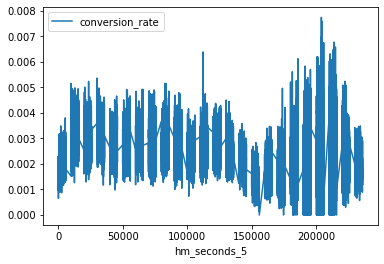

In [10]:
conversion_seconds_5.plot(x ='hm_seconds_5', y='conversion_rate', kind = 'line')
plt.show()

In [11]:
df = conversion_seconds_5
df.loc[(df['is_attributed'] != 0), 'threshold'] = df['click_time']/df['is_attributed']

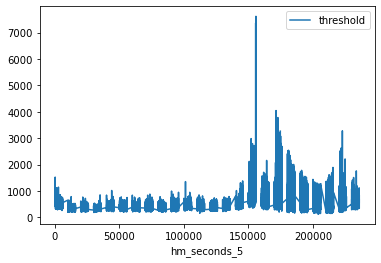

In [12]:
df.plot(x ='hm_seconds_5', y='threshold', kind = 'line')
plt.show()

In [13]:
co = conversion_seconds_5[conversion_seconds_5['conversion_rate']==0]
Q1 = co.click_time.quantile(0.25)
Q3 = co.click_time.quantile(0.75)
IQR = Q3 - Q1
click_outlier = Q3 + 1.5 * IQR
print("Number of clicks threshold: ", click_outlier)

Number of clicks threshold:  2043.0


In [14]:
Q1 = df.threshold.quantile(0.25)
Q3 = df.threshold.quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR
print("Clicks squared per downloads threshold: ", threshold)

Clicks squared per downloads threshold:  841.8789682539683


In [15]:
df.loc[(df['is_attributed'] == 0) & (df['click_time'] > click_outlier), 'isFraud'] = 1
df.loc[(df['is_attributed'] != 0) & (df['threshold'] > threshold), 'isFraud'] = 1
df.loc[(df['isFraud'].isnull()), 'isFraud'] = 0

In [16]:
new_data = pd.merge(train_2days, df[['hm_seconds_5', 'isFraud']], on='hm_seconds_5', how='left')
new_data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,seconds_5,hm_seconds_5,isFraud
0,70712,2,1,32,237,2017-11-07,NaN,0,7,0,00,0,01,1,0.0
1,45892,3,1,25,424,2017-11-07,NaN,0,7,0,00,0,01,1,0.0
2,37774,8,2,13,145,2017-11-07,NaN,0,7,0,00,0,01,1,0.0
3,41179,2,1,13,122,2017-11-07,NaN,0,7,0,00,0,01,1,0.0
4,83111,15,1,8,245,2017-11-07,NaN,0,7,0,00,0,01,1,0.0


In [17]:
event_rate = new_data.isFraud.sum()/len(new_data)
print("Event rate per 5 seconds using clicks per downloads threshold: ", event_rate)

Event rate per 5 seconds using clicks per downloads threshold:  0.04541721609401201
